In [1]:
import numpy as np

def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2

def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)

def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype = np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    
    for i in range(number_of_classes):
        weights[:, :, i, i] = upsample_kernel
    
    return weights

In [2]:
%matplotlib inline
from __future__ import division

import os
import sys
import tensorflow as tf

from matplotlib import pyplot as plt

slim = tf.contrib.slim
sys.path.append(os.path.expanduser("F:/tensorflow1.5/models/research/slim"))

from nets import vgg
from preprocessing import vgg_preprocessing

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

checkpoint_dir = os.path.expanduser('F:/tensorflow1.5/models/research/data/pre_trained/vgg_16_2016_08_28/')

image_filename = 'F:/tensorflow1.5/models/research/data/2010_001448.jpg'
annotation_filename = 'F:/tensorflow1.5/models/research/data/2010_001448.png'

fig_size = [15, 4]
plt.rcParams["figure.figsize"] = fig_size

In [4]:
tf.reset_default_graph()
image_filename_placeholder = tf.placeholder(tf.string)
annotation_filename_placeholder = tf.placeholder(tf.string)
is_training_placeholder = tf.placeholder(tf.bool)

feed_dict_to_use = {image_filename_placeholder: image_filename,
                    annotation_filename_placeholder: annotation_filename,
                    is_training_placeholder: True}
image_tensor = tf.read_file(image_filename_placeholder)
annotation_tensor = tf.read_file(annotation_filename_placeholder)

image_tensor = tf.image.decode_jpeg(image_tensor, channels=3)
annotation_tensor = tf.image.decode_png(annotation_tensor, channels=1)

# Get ones for each class instead of a number -- we need that
# for cross-entropy loss later on. Sometimes the groundtruth
# masks have values other than 1 and 0.
class_labels_tensor = tf.greater_equal(annotation_tensor, 1)
background_labels_tensor = tf.less(annotation_tensor, 1)

# Convert the boolean values into floats -- so that
# computations in cross-entropy loss is correct.
bit_mask_class = tf.to_float(class_labels_tensor)
bit_mast_background = tf.to_float(background_labels_tensor)

combined_mask = tf.concat(axis=2, values=[bit_mast_background,
                                          bit_mask_class,])

# Lets reshape out input so that it becomes suitable for
# tf.softmax_cross_entropy_with_logits with [batch_size, num_classes].
flat_labels = tf.reshape(tensor=combined_mask, shape=(-1, 2))

In [5]:
# Load the mean pixel values and the function
# that performs the subtraction from each pixel.
from preprocessing.vgg_preprocessing import (_mean_image_subtraction,
                                             _R_MEAN, _G_MEAN, _B_MEAN)

upsample_factor = 32
number_of_classes = 2
log_folder = os.path.expanduser("segment_log_folder")

vgg_checkpoint_path = os.path.join(checkpoint_dir, 'vgg_16.ckpt')

# Convert image to float32 before subtracting the
# mean pixel value
image_float = tf.to_float(image_tensor, name="ToFloat")

original_shape = tf.shape(image_tensor)[0:2]

# Subtract the mean pixel value from each pixel.
mean_centered_image = _mean_image_subtraction(image_float,
                                             [_R_MEAN, _G_MEAN, _B_MEAN])

target_input_size_factor = tf.ceil(
    tf.div(tf.to_float(original_shape),
           tf.to_float(upsample_factor)))
target_input_size = tf.to_int32(tf.multiply(target_input_size_factor, upsample_factor))
padding_size = (target_input_size - original_shape) // 2

mean_centered_image = tf.image.pad_to_bounding_box(mean_centered_image,
                                                  padding_size[0],
                                                  padding_size[1],
                                                  target_input_size[0],
                                                  target_input_size[1])

processed_image = tf.expand_dims(mean_centered_image, 0)
upsample_filter_np = bilinear_upsample_weights(upsample_factor,
                                               number_of_classes)

upsample_filter_tensor = tf.Variable(upsample_filter_np, name="vgg_16/fc8/t_conv")

# Define the model that we want to use -- spectify to use only two classes at the last layer.
with slim.arg_scope(vgg.vgg_arg_scope()):
    logits, end_points = vgg.vgg_16(processed_image,
                                   num_classes=2,
                                   is_training=is_training_placeholder,
                                   spatial_squeeze=False,
                                   fc_conv_padding="SAME")
    
downsample_logits_shape = tf.shape(logits)

# Calculate the out put size of the upsampled tensor.
upsample_logits_shape = tf.stack([downsample_logits_shape[0],
                        original_shape[0], # downsampled_logists_shape[1] * upsample_factor
                        original_shape[1], # downsampled_logists_shape[2] * upsample_factor
                        downsample_logits_shape[3]])

# Perform the upsampling.
upsampled_logits = tf.nn.conv2d_transpose(logits, upsample_filter_tensor,
                                          output_shape=upsample_logits_shape,
                                          strides=[1, upsample_factor, upsample_factor, 1],
                                          padding="SAME")

# Flatten the prediction, so that we can compute cross-entropy for
# each pixel and get a sum of cross-entroies.
flat_logits = tf.reshape(tensor=upsampled_logits, shape=[-1, number_of_classes])

cross_entropies = tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits,
                                                          labels=flat_labels)

cross_entropy_sum = tf.reduce_sum(cross_entropies)

# Tensor to get the final prediction for each pixel -- pay
# attention that we don't need softmax in this case beacase
# we only need the final decision. If we also need the respective
# probabilities we will have to apply softmax.
pred = tf.argmax(upsampled_logits, axis=3)

probabilities = tf.nn.softmax(upsampled_logits)

# Here we define an optimizer and put all the variables
# that will be created under a namespace of 'adam_vars'.
# This is done so that we can easily access them later.
# Those variables are used by adam optimizer and are not
# related to variables of the vgg model.

# We also retrieve gradient Tensors for each of out variables
# This way we can later visualize them in tensorboard.
# optimizer.compute_gradients and optimizer.apply_gradients
# is equivalent to running:
# train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cross_entropy_sum)
with tf.variable_scope('adam_vars'):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4)
    gradients = optimizer.compute_gradients(loss=cross_entropy_sum)
    
    for grad_var_pair in gradients:
        current_variable = grad_var_pair[1]
        current_gradient = grad_var_pair[0]
        
        # Relace some characters from the original variable name
        # tensorboard doesn't accept ':' symbol
        gradients_name_to_save = current_variable.name.replace(':', '_')
        
        # Let's get histogram of gradients for each layer and 
        # visualize them later in tensorboard.
        tf.summary.histogram(gradients_name_to_save, current_gradient)
    
    train_step = optimizer.apply_gradients(grads_and_vars=gradients)

# Now we define a function that will load the weights from VGG checkpoint
# into our variables when we call it. We exclude the weights from the last layer
# which is responsible for class predictions. We do this because
# we will have different number of classes to predict and we can't
# use the old ones as an initalization.
vgg_except_fc8_weights = slim.get_variables_to_restore(exclude=['vgg_16/fc8', 'adam_vars'])

# Here we get variables that belong to the last layer of network.
# As we saw, the number of classes that VGG was orifinally trained on
# is different from ours -- in our case it is only 2 classes.
vgg_fc8_weights = slim.get_variables_to_restore(include=['vgg_16/fc8'])

adam_optimizer_variables = slim.get_variables_to_restore(include=['adam_vars'])

# Add summary op for the loss -- to be able to see it in tensorboard.
tf.summary.scalar('cross_entropy_loss', cross_entropy_sum)

# Put all summary ops into one op. Produces string when you run it.
merge_summary_op = tf.summary.merge_all()

# Create the summary writer -- to write all the logs
# into a specified file. This file can be later read
# by tensorboard.
summary_string_writer = tf.summary.FileWriter(log_folder)

# Create the log folder if doesn't exist yet.
if not os.path.exists(log_folder):
    os.makedirs(log_folder)
    
# Create an OP that performs the initialization of
# values of variables to the values from VGG.
read_vgg_weights_except_fc8_func = slim.assign_from_checkpoint_fn(
                                   vgg_checkpoint_path,
                                   vgg_except_fc8_weights)

# Initializer for new fc8 weights -- for two classes.
vgg_fc8_weights_initializer = tf.variables_initializer(vgg_fc8_weights)

# Initializer for adam variables.
optimization_variables_initializer = tf.variables_initializer(adam_optimizer_variables)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



INFO:tensorflow:Restoring parameters from F:/tensorflow1.5/models/research/data/pre_trained/vgg_16_2016_08_28/vgg_16.ckpt


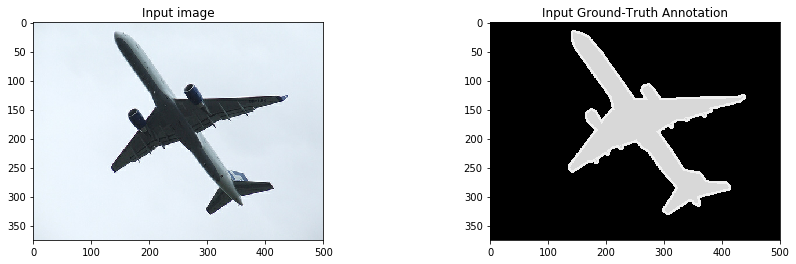

(4,)


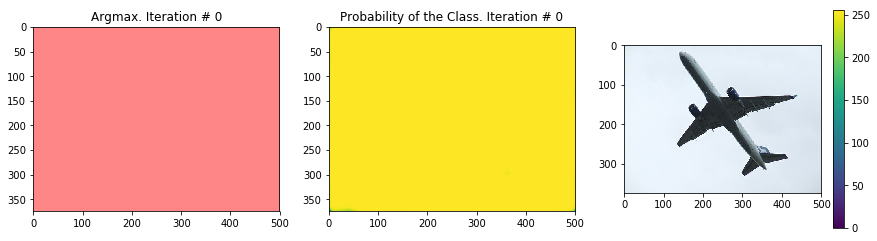

Current Loss: 169306.62


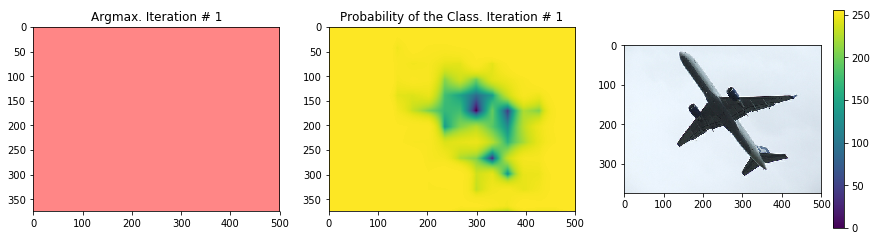

Current Loss: 526396.4


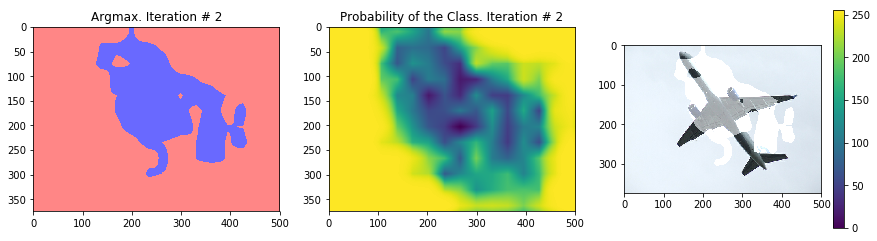

Current Loss: 125033.25


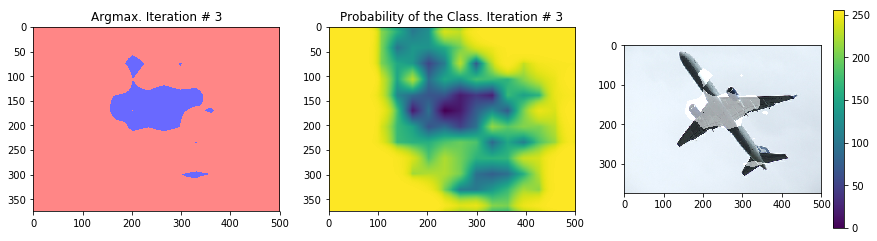

Current Loss: 59764.13


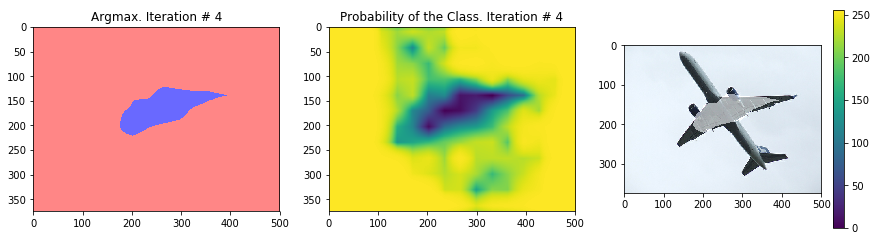

Current Loss: 44842.47


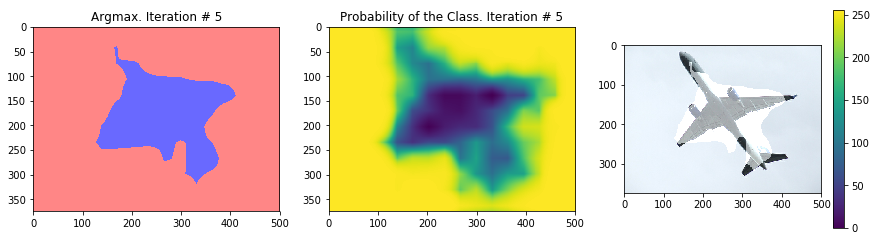

Current Loss: 40304.242


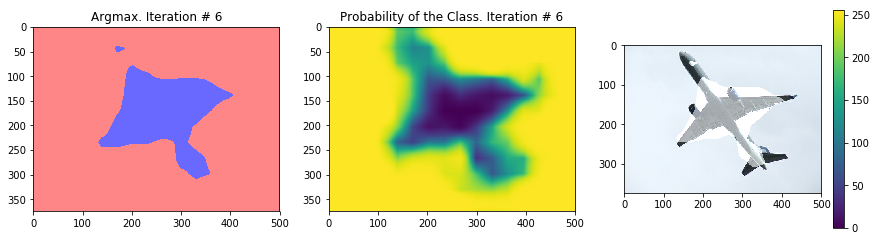

Current Loss: 39148.117


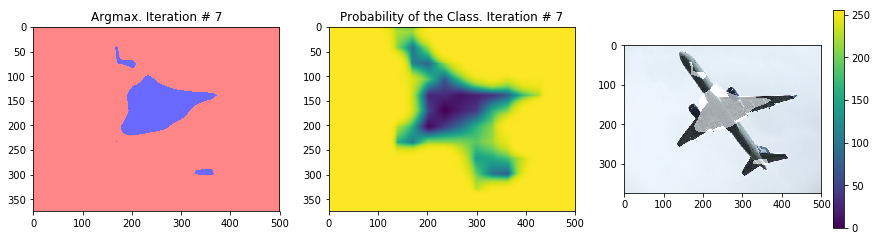

Current Loss: 32190.422


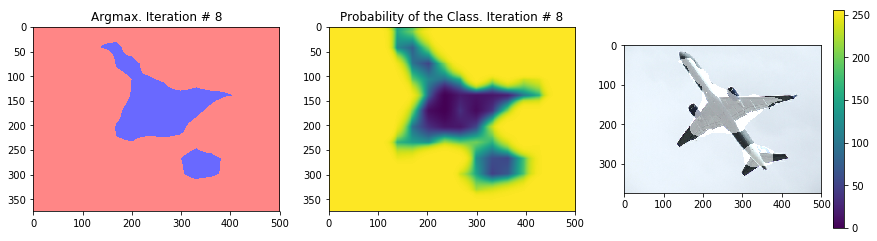

Current Loss: 32042.72


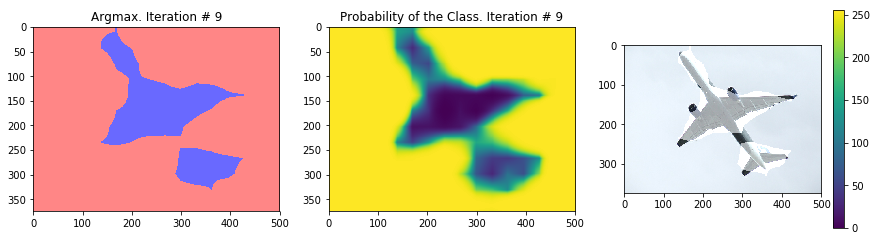

Current Loss: 24156.727


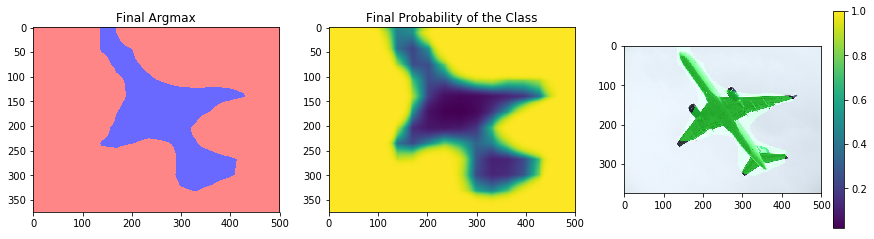

Final Loss: 25391.016


In [10]:
init_op = tf.global_variables_initializer()
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = False
sess = tf.Session(config=sess_config)

with sess:
    # Run the initializers.
    sess.run(vgg_fc8_weights_initializer)
    sess.run(optimization_variables_initializer)
    read_vgg_weights_except_fc8_func(sess)
    
    train_image, train_annotation = sess.run([image_tensor, annotation_tensor],
                                              feed_dict=feed_dict_to_use)
    plt.figure(1)
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.imshow(train_image)
    ax1.set_title('Input image')
    probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
    ax2.set_title('Input Ground-Truth Annotation')
    plt.show()
    
    downsample_logits_value, train_annotation = sess.run(
                                                [downsample_logits_shape, annotation_tensor],
                                                 feed_dict=feed_dict_to_use)
    print(downsample_logits_shape.shape)
    
    # Let's perform 10 interactions
    for i in range(10):
        loss, summary_string = sess.run([cross_entropy_sum, merge_summary_op],
                                         feed_dict=feed_dict_to_use)
        
        sess.run(train_step, feed_dict=feed_dict_to_use)
        
        pred_np, probabilities_np = sess.run([pred, probabilities],
                                              feed_dict=feed_dict_to_use)
        summary_string_writer.add_summary(summary_string, i)
        
        cmap = plt.get_cmap('bwr')
        
        plt.figure(2)
        ax1 = plt.subplot(131)
        ax2 = plt.subplot(132)
        ax3 = plt.subplot(133)
        ax1.imshow(np.uint8(pred_np.squeeze() != 1), vmax=1.5, vmin=-0.4, cmap=cmap)
        ax1.set_title('Argmax. Iteration # ' + str(i))
        probability_graph = ax2.imshow(probabilities_np.squeeze()[:, :, 0])
        ax2.set_title('Probability of the Class. Iteration # ' + str(i))
        mask = np.multiply(np.uint32(pred_np.squeeze()), 128)
        mask = np.stack([mask,]*3, axis=-1)
        masked_image = np.uint8(np.clip(train_image+mask, 0, 255))
        probability_graph = ax3.imshow(masked_image)
        plt.colorbar(probability_graph)
        plt.show()
        
        print("Current Loss: " + str(loss))
    
    feed_dict_to_use[is_training_placeholder] = False
    
    final_predictions, final_probabilities, final_loss = sess.run([pred,
                                                                   probabilities,
                                                                   cross_entropy_sum],
                                                         feed_dict=feed_dict_to_use)
    plt.figure(3)
    ax1 = plt.subplot(131)
    ax2 = plt.subplot(132)
    ax3 = plt.subplot(133)
    
    ax1.imshow(np.uint8(final_predictions.squeeze() != 1),
               vmax=1.5,
               vmin=-0.4,
               cmap=cmap)
    
    ax1.set_title('Final Argmax')
    
    probability_graph = ax2.imshow(final_probabilities.squeeze()[:, :, 0])
    ax2.set_title('Final Probability of the Class')
    plt.colorbar(probability_graph)
    
    mask = np.multiply(np.uint32(final_predictions.squeeze()), 128)
    #mask = np.stack([mask,]*3, axis=-1)
    mask = np.stack([np.zeros(mask.shape),
                     mask,
                     np.zeros(mask.shape)], axis=-1)
    masked_image = np.uint8(np.clip(train_image+mask, 0, 255))
    probability_graph = ax3.imshow(masked_image)
    
    plt.show()
    
    print("Final Loss: " + str(final_loss))
    
summary_string_writer.close()

对结果进行CRF处理。使用了cython版本的crf。

安装方法： pip install git+https://github.com/lucasb-eyer/pydensecrf.git

(2, 187500)


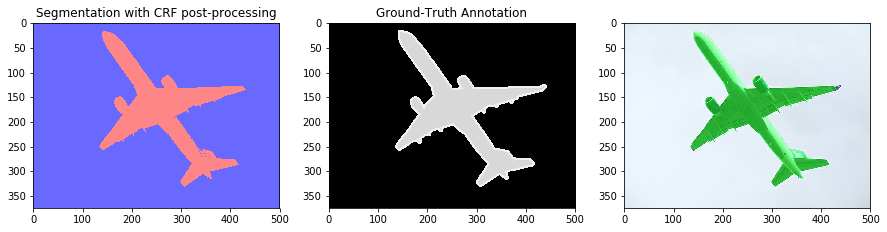

IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%IoU:0.90%


In [14]:
import sys
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, \
     create_pairwise_gaussian, softmax_to_unary

image = train_image
    
processed_probabilities = final_probabilities.squeeze()

softmax = processed_probabilities.transpose((2, 0, 1))

# The input should be the negative of the logarithm of probability values
# Look up the definition of the softmax_to_unary for more information
unary = softmax_to_unary(softmax)
print(unary.shape)
# The input should be C-continious -- we are using Cython wrapper
unary = np.ascontiguousarray(unary)

d = dcrf.DenseCRF(image.shape[0] * image.shape[1], 2)

d.setUnaryEnergy(unary)

# This potential penalizes small pieces of segmentation that are
# spatially isolated -- enforces more spatially consistent segmentations
feats = create_pairwise_gaussian(sdims=(10, 10), shape=image.shape[:2])

d.addPairwiseEnergy(feats, compat=3,
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)

# This creates the color-dependent features --
# because the segmentation that we get from CNN are too coarse
# and we can use local color features to refine them
feats = create_pairwise_bilateral(sdims=(50, 50), schan=(20, 20, 20),
                                  img=image, chdim=2)

d.addPairwiseEnergy(feats, compat=10,
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)

Q = d.inference(5)

res = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))

cmap = plt.get_cmap('bwr')

plt.figure(4)
ax1 = plt.subplot(131)
ax2 = plt.subplot(132)
ax3 = plt.subplot(133)
ax1.imshow(res, vmax=1.5, vmin=-0.4, cmap=cmap)
ax1.set_title('Segmentation with CRF post-processing')
probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
ax2.set_title('Ground-Truth Annotation')

mask = np.multiply(np.uint32(res.squeeze()), 128)
mask = np.stack([np.zeros(mask.shape),
                 mask,
                 np.zeros(mask.shape)], axis=-1)
masked_image = np.uint8(np.clip(np.uint32(train_image)+mask, 0, 255))
probability_graph = ax3.imshow(masked_image)

plt.show()

intersection = np.logical_and(res, train_annotation.squeeze())
union = np.logical_or(res, train_annotation.squeeze())
sum_intersection = np.sum(intersection)
sum_union = np.sum(union)

print("IoU:%.2f%%" % ((sum_intersection/sum_union)*100))